This notebook addresses some specific reviewer concerns about the top-k spectrogram procedure.

Running this notebook requires MVPy, which is a package in which I collect some functionality to make GPU-based neuro analysis easier. Install it in the following cell.

In [ ]:
%pip install git+https://github.com/FabulousFabs/MVPy.git

Next, we need a bunch of imports and define our top-k function.

In [1]:
import sys
import mvpy as mv
from sklearn.pipeline import make_pipeline

import re, time, warnings, os, copy
from typing import Union, Dict
import gzip, pickle

import numpy as np
import pandas as pd
import gzip, pickle
import scipy, sklearn, mne

import auxiliary as aux
import data, rsa
sys.path.append('../../spaces/')
import embeddings as emb
import pubplot as pub
import matplotlib.pyplot as plt

from typing import Union, Dict, Any, Callable

pub.styles.set()
C = pub.colours.equidistant('tab20c', k = 20)

def get_topk(n_topk: int, beh: pd.core.frame.DataFrame, targets: np.ndarray, priors: np.ndarray, G: Any, va: int, context: Union[str, None] = None, contexts: np.ndarray = np.array(['essen', 'fashion', 'outdoor', 'technik', 'politik', 'unterhaltung'])) -> np.ndarray:
    '''
    Obtain the expected audio given a top-k prediction.
    
    INPUTS:
        n_topk   -  Number of top-k predictions to consider
        beh      -  Behavioral data frame
        targets  -  Array of all the target words
        priors   -  Semantic priors
        G        -  Semantic space
        va       -  Variant_a of the morph
        context  -  Context of the morph
        contexts -  All contexts (in the correct order, relative to priors) (default = ['essen', 'fashion', 'outdoor', 'technik', 'politik', 'unterhaltung'])
    
    OUTPUTS:
        exp      -  Expected audio (`features` x `time`)
        prior_k
        expectation
    '''
    
    # find context id and candidates
    if context is None:
        c_id = 0
        candidates = np.unique(beh.options_0.tolist())
    else: 
        c_id = np.where(contexts == context)[0]
        candidates = np.unique(beh.loc[(beh.context == context)].options_0.tolist())
    
    # find semantics and goodness of fit
    semantics = np.zeros((len(candidates), 50))
    fits = np.zeros((len(candidates)))
    
    for j, word in enumerate(candidates):
        semantics[j,:] = G[word.lower()]
        fits[j] = rsa.math.cosine(priors[c_id,:].squeeze(), semantics[j,:])
    
    # determine top-k
    order = fits.argsort()[::-1]
    topk = order[0:n_topk]
    
    # setup expectations
    expectation = np.zeros((n_topk, max_L, 28))
    files = []
    
    # ignore NaNs produced by zeros
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        
        for j, k in enumerate(topk):
            # find morph where this item would be target
            indx = np.where(targets == candidates[k])[0][0]

            # find associated a & b
            morph_k = labels[indx]
            k_a, k_b = morph_k.split('_')[0].split('-')

            # find associated audio file
            T = 'T' if k_a.lower() == candidates[k].lower() else 'D'

            # load gammatone
            y_k = np.load(f'./data/preprocessed/audio/gt-{fs}Hz/clear/{k_a}-{k_b}_{T}{va}.npy')

            # track expectation
            L_k = min(200, y_k.shape[1])
            expectation[j,0:L_k] = y_k[:,0:L_k].T
    
    # create acoustic prior
    prior_k = (fits[topk] + 1 ) / 2 # normalise to [0, 1]
    prior_k = prior_k / prior_k.sum() # take softmax
    exp_audio = (prior_k[:,None,None] * expectation).sum(axis = 0).T
    
    return exp_audio, prior_k, expectation

Let's load training data for phoneme decoding (Alice in Wonderland) as well as top-k spectrograms, the individual spectrograms and their weights, and context identities.

In [2]:
import re

# load phoneme training data
narrative = np.load(f'./data/preprocessed/audio/gt-200Hz/narrative/narrative.npy')
df = pd.read_csv(f'./data/preprocessed/audio/annotated/narrative/narrative.csv', delimiter = ';')

# clean up phonemes quickly
df = df.loc[
    (df.MAU != '<p:>') & # remove breaks
    (df.MAU != '?') # remove glottal stops bc not phonemic in German
].reset_index(drop = True)

# remove elongations
df['phoneme'] = df['MAU'].apply(
    lambda x: re.compile(r'[^a-z@0-9]+', re.IGNORECASE).sub('', x)
)

# set tags
conv = lambda x: int((x / 32000) * 200)
df['onset'] = df['BEGIN'].apply(conv)
df['length'] = df['DURATION'].apply(conv)
df['offset'] = df['onset'] + df['length']

# remove phonemes with low counts
phonemes, n_counts = np.unique(df.phoneme.tolist(), return_counts = True)
n_min_count = 20
mask = n_counts >= n_min_count
phonemes, n_counts = phonemes[mask], n_counts[mask]
df = df.loc[
    (np.isin(df.phoneme, phonemes))
].reset_index(drop = True)

# read data
dec_L = 60
X = []
labels = []

for i in range(len(df)):
    pho = df.loc[i]
    on, off = pho.onset, pho.offset
    label = pho.phoneme
    
    X.append(
        narrative[:,on:on+dec_L]
    )
    
    labels.append(np.where(phonemes == label)[0])

X = np.array(X)
y_labels = np.array(labels)[:,:,None]

# load subject data
id = '0002'
subject = data.Subjects[id]
sid, pid = subject.sid, subject.pid

n_topk = 5

dir_out = f'./data/processed/eeg/sub{sid}/'

with gzip.open(f'{dir_out}rec-data.pkl.gz', 'rb') as f:
    (_, _, labels, targets, _, _, y, _, _, y_h_mt1, _) = pickle.load(f)
max_L = y.shape[2]
fs = 200

G = emb.glove.load_embedding(f_in = './data/preprocessed/misc/glove/w2v_50D.txt') # mini version

beh = pd.read_csv(f'./data/raw/beh/sub{sid}/{pid}.csv')
beh = beh.loc[(beh.type == data.defs.TRIAL_MT_MAIN)].reset_index(drop = True)
contexts = np.array(['essen', 'fashion', 'outdoor', 'technik', 'politik', 'unterhaltung'])
priors = np.random.normal(loc = 0, scale = 0.1, size = (6, 50))

topk = []
topk_c = []
probs = []
speaker = []

for i in range(len(labels)):
    # grab trial data
    label, trial = labels[i], beh.loc[i]
    context = trial.context
    
    # grab descriptors from label
    a, b = label.split('_')[0].split('-')
    va, vb = label.split('_')[1].split('-')
    r = int(label.split('_')[4][1])
    
    # get context id
    c_id = np.where(contexts == context)[0][0]
    speaker.append(c_id)
    
    # get expected audios
    exp, p, full = get_topk(n_topk, beh, targets, priors, G, va, context = context)
    topk.append(exp)
    topk_c.append(full)
    probs.append(p)
    
    # update priors
    with gzip.open(f'./data/raw/rtfe/sub{sid}/{pid}_t{trial.no}_{context}.pkl.gz', 'rb') as f:
        _, _, _, posterior, _, _ = pickle.load(f)
    priors = posterior.T

topk = np.array(topk)
topk_c = np.array(topk_c).swapaxes(2, 3)
probs = np.array(probs)
speaker = np.array(speaker)

Quick check to verify data are shaped nicely (n_trials[, n_topk], n_channels, n_timepoints).

In [3]:
X.shape, y_labels.shape, topk.shape, topk_c.shape, probs.shape

((3376, 28, 60), (3376, 1, 1), (240, 28, 200), (240, 5, 28, 200), (240, 5))

Quick check to verify classes.

In [4]:
np.unique(y_labels).shape

(33,)

Now, we want to train phoneme decoders over Alice in Wonderland data and apply them to our top-k spectrograms and their constituent counterparts.

In [5]:
from mvpy.preprocessing import Scaler
from mvpy.estimators import Sliding, RidgeClassifier
from mvpy.crossvalidation import RepeatedStratifiedKFold
from mvpy import metrics

# parameters
n_splits = 5
n_repeats = 1

# model setup
clf = make_pipeline(
    Scaler().to_numpy(),
    Sliding(
        RidgeClassifier(
            np.logspace(-5, 10, 20)
        ),
        dims = np.array([-1]),
        verbose = True,
        n_jobs = 8
    )
)

# cross-validation setup
kf = RepeatedStratifiedKFold(
    n_splits = n_splits, 
    n_repeats = n_repeats
)

# data containers
oos = np.zeros((n_splits * n_repeats, dec_L))
oos_topk = np.zeros((n_splits * n_repeats, topk.shape[0], phonemes.shape[0], topk.shape[-1] - dec_L))
oos_topk_c = np.zeros((n_splits * n_repeats, topk.shape[0], topk_c.shape[1], phonemes.shape[0], topk.shape[-1] - dec_L))
classes = np.unique(y_labels)
topkc_flat = topk_c.reshape((-1, *topk_c.shape[2:]))

# loop over CV folds
for f_i, (train, test) in enumerate(kf.split(X[:,:,0], y_labels[:,0,0])):
    # equalise training counts
    _, n_min_count_i = np.unique(y_labels[train], return_counts = True)
    n_min_count_i = n_min_count_i.min()
    res_train = np.array([
        np.where(y_labels[train] == class_i)[0][0:n_min_count_i]
        for class_i in classes
    ]).flatten()
    train = train[res_train]
    
    # equalise test counts
    _, n_min_count_i = np.unique(y_labels[test], return_counts = True)
    n_min_count_i = n_min_count_i.min()
    res_test = np.array([
        np.where(y_labels[test] == class_i)[0][0:n_min_count_i]
        for class_i in classes
    ]).flatten()
    test = test[res_test]
    
    # train
    clf.fit(X[train], y_labels[train])
    
    # eval decoder
    oos[f_i] = metrics.score(
        clf, metrics.accuracy, X[test], y_labels[test] * np.ones((test.shape[0], 1, X.shape[-1]))
    )
    
    # apply to top-k and individual constituents
    for t_start in range(topk.shape[-1] - dec_L):
        oos_topk[f_i,:,:,t_start] = clf.predict_proba(
            topk[...,t_start:t_start+dec_L]
        ).mean(-1)
        
        oos_topk_c[f_i,:,:,:,t_start] = clf.predict_proba(
            topkc_flat[...,t_start:t_start+dec_L]
        ).mean(-1).reshape((topk_c.shape[0], topk_c.shape[1], phonemes.shape[0]))

Fitting estimators...:   0%|          | 0/60 [00:00<?, ?it/s]

Fitting estimators...:   0%|          | 0/60 [00:00<?, ?it/s]

Fitting estimators...:   0%|          | 0/60 [00:00<?, ?it/s]

Fitting estimators...:   0%|          | 0/60 [00:00<?, ?it/s]

Fitting estimators...:   0%|          | 0/60 [00:00<?, ?it/s]

Let's visualise quickly that this works as intended (out-of-sample in AiW).

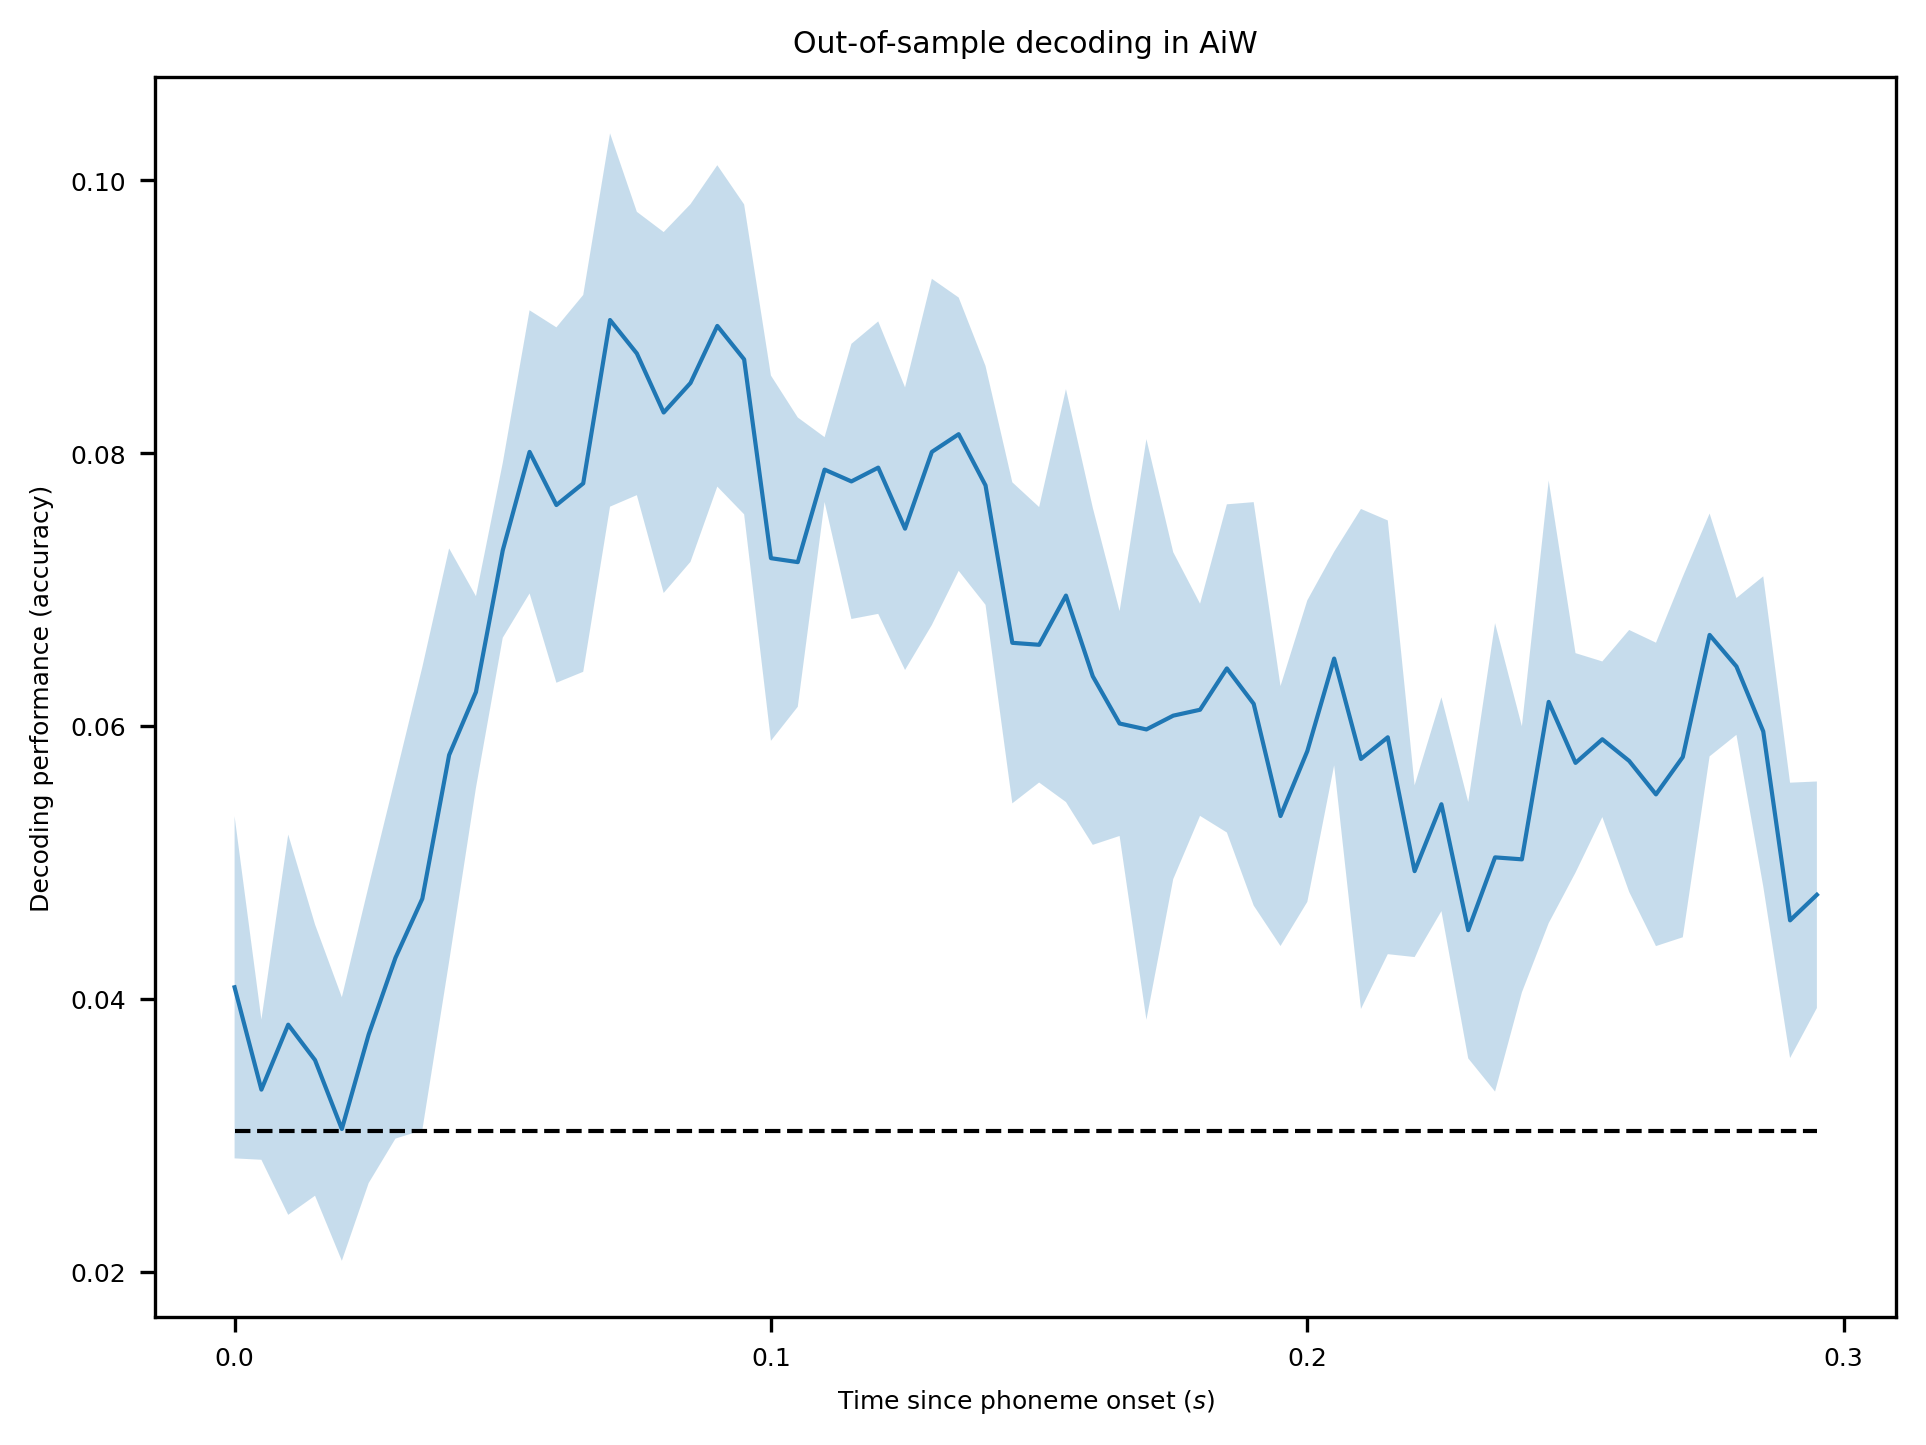

In [6]:
fig, ax = plt.subplots()

# compute mean, se, chance
mu = oos.mean(0)
se = oos[np.random.choice(np.arange(oos.shape[0]), replace = True, size = (1000, oos.shape[0]))]
se = se.mean(1).std(0)
t = np.arange(mu.shape[0])
chance = [1 / np.unique(y_labels).shape[0]] * len(t)

# plot
ax.plot(t, chance, color = 'black', linestyle = '--')
ax.fill_between(t, mu - 1.96 * se, mu + 1.96 * se, alpha = 0.25)
ax.plot(t, mu)

# cosmetics
ax.set_xlabel(r'Time since phoneme onset ($s$)')
ax.set_xticks(np.arange(0, mu.shape[0] + 1, 20))
ax.set_xticklabels(np.arange(0, mu.shape[0] + 1, 20)*5e-3)
ax.set_ylabel(r'Decoding performance (accuracy)')
ax.set_title(fr'Out-of-sample decoding in AiW')
fig.tight_layout()

Now, let's compare our results between decoding the top-k spectrograms and weighing the decoded probabilities from individual constituents.

In [7]:
r = mv.math.pearsonr(
    oos_topk.mean(0).swapaxes(1, 2), 
    (oos_topk_c.mean(0) * probs[...,None,None]).mean(1).swapaxes(1, 2)
).mean()

print(f'Pearson r: {r:.2f}')

Pearson r: 1.00


Neat. Now, let's look at whether this also holds for cosine similarities instead of decoding.

Note that, for cosine similarity, things are a bit different; They principally break the equality detailed in the supplement through the use of norms. However, we should still see that substantial variance is preserved -- depending on the exact distribution of the data. To check this, we will also compute permuted matrices that should land near (or on) zero as a comparison.

In [8]:
# create estimator
rsa = make_pipeline(
    mv.estimators.RSA(
        estimator = mv.math.cosine,
        verbose = True,
        n_jobs = 8
    ).to_numpy()
)

# compute rdms
rdm_topk = rsa.fit(topk)[-1].full_rdm().copy()

rdm_topk_c = np.array([
    rsa.fit(topk_c[:,k,:,:])[-1].full_rdm().copy()
    for k in range(n_topk)
])

perm = np.arange(topk_c.shape[0])
np.random.shuffle(perm)
rdm_topk_c_perm = np.array([
    rsa.fit(topk_c[perm,k,:,:])[-1].full_rdm().copy()
    for k in range(n_topk)
])

Computing RDM...:   0%|          | 0/200 [00:00<?, ?it/s]

/Users/fabianschneider/mambaforge/envs/sempriors/lib/python3.10/site-packages/mvpy/math/cosine.py:31: RuntimeWarning: invalid value encountered in divide
  return np.sum(x * y, axis = -1) / (np.linalg.norm(x, axis = -1) * np.linalg.norm(y, axis = -1))
/Users/fabianschneider/mambaforge/envs/sempriors/lib/python3.10/site-packages/mvpy/math/cosine.py:31: RuntimeWarning: invalid value encountered in divide
  return np.sum(x * y, axis = -1) / (np.linalg.norm(x, axis = -1) * np.linalg.norm(y, axis = -1))
/Users/fabianschneider/mambaforge/envs/sempriors/lib/python3.10/site-packages/mvpy/math/cosine.py:31: RuntimeWarning: invalid value encountered in divide
  return np.sum(x * y, axis = -1) / (np.linalg.norm(x, axis = -1) * np.linalg.norm(y, axis = -1))
/Users/fabianschneider/mambaforge/envs/sempriors/lib/python3.10/site-packages/mvpy/math/cosine.py:31: RuntimeWarning: invalid value encountered in divide
  return np.sum(x * y, axis = -1) / (np.linalg.norm(x, axis = -1) * np.linalg.norm(y, axis

Computing RDM...:   0%|          | 0/200 [00:00<?, ?it/s]

/Users/fabianschneider/mambaforge/envs/sempriors/lib/python3.10/site-packages/mvpy/math/cosine.py:31: RuntimeWarning: invalid value encountered in divide
  return np.sum(x * y, axis = -1) / (np.linalg.norm(x, axis = -1) * np.linalg.norm(y, axis = -1))
/Users/fabianschneider/mambaforge/envs/sempriors/lib/python3.10/site-packages/mvpy/math/cosine.py:31: RuntimeWarning: invalid value encountered in divide
  return np.sum(x * y, axis = -1) / (np.linalg.norm(x, axis = -1) * np.linalg.norm(y, axis = -1))
/Users/fabianschneider/mambaforge/envs/sempriors/lib/python3.10/site-packages/mvpy/math/cosine.py:31: RuntimeWarning: invalid value encountered in divide
  return np.sum(x * y, axis = -1) / (np.linalg.norm(x, axis = -1) * np.linalg.norm(y, axis = -1))
/Users/fabianschneider/mambaforge/envs/sempriors/lib/python3.10/site-packages/mvpy/math/cosine.py:31: RuntimeWarning: invalid value encountered in divide
  return np.sum(x * y, axis = -1) / (np.linalg.norm(x, axis = -1) * np.linalg.norm(y, axis

Computing RDM...:   0%|          | 0/200 [00:00<?, ?it/s]

Computing RDM...:   0%|          | 0/200 [00:00<?, ?it/s]

Computing RDM...:   0%|          | 0/200 [00:00<?, ?it/s]

Computing RDM...:   0%|          | 0/200 [00:00<?, ?it/s]

Computing RDM...:   0%|          | 0/200 [00:00<?, ?it/s]

Computing RDM...:   0%|          | 0/200 [00:00<?, ?it/s]

Computing RDM...:   0%|          | 0/200 [00:00<?, ?it/s]

Computing RDM...:   0%|          | 0/200 [00:00<?, ?it/s]

Computing RDM...:   0%|          | 0/200 [00:00<?, ?it/s]

Let's compute correlations again.

In [9]:
# grab indices
tri_x, tri_y = np.triu_indices(rdm_topk.shape[0], k = 1)

# remove NaNs
rdm_topk[np.isnan(rdm_topk)] = 0.0
rdm_topk_c[np.isnan(rdm_topk_c)] = 0.0
rdm_topk_c_perm[np.isnan(rdm_topk_c_perm)] = 0.0

# compute correlation
r = mv.math.pearsonr(
    rdm_topk[tri_x,tri_y,:].T,
    (rdm_topk_c * probs.T[:,:,None,None]).sum(axis = 0)[tri_x,tri_y,:].T
)

# compute permuted correlation
r_perm = mv.math.pearsonr(
    rdm_topk[tri_x,tri_y,:].T,
    (rdm_topk_c_perm * probs.T[:,perm,None,None]).sum(axis = 0)[tri_x,tri_y,:].T
)

Let's visualise this quickly and show that substantial shared variance persists, albeit imperfectly in the cosine case.

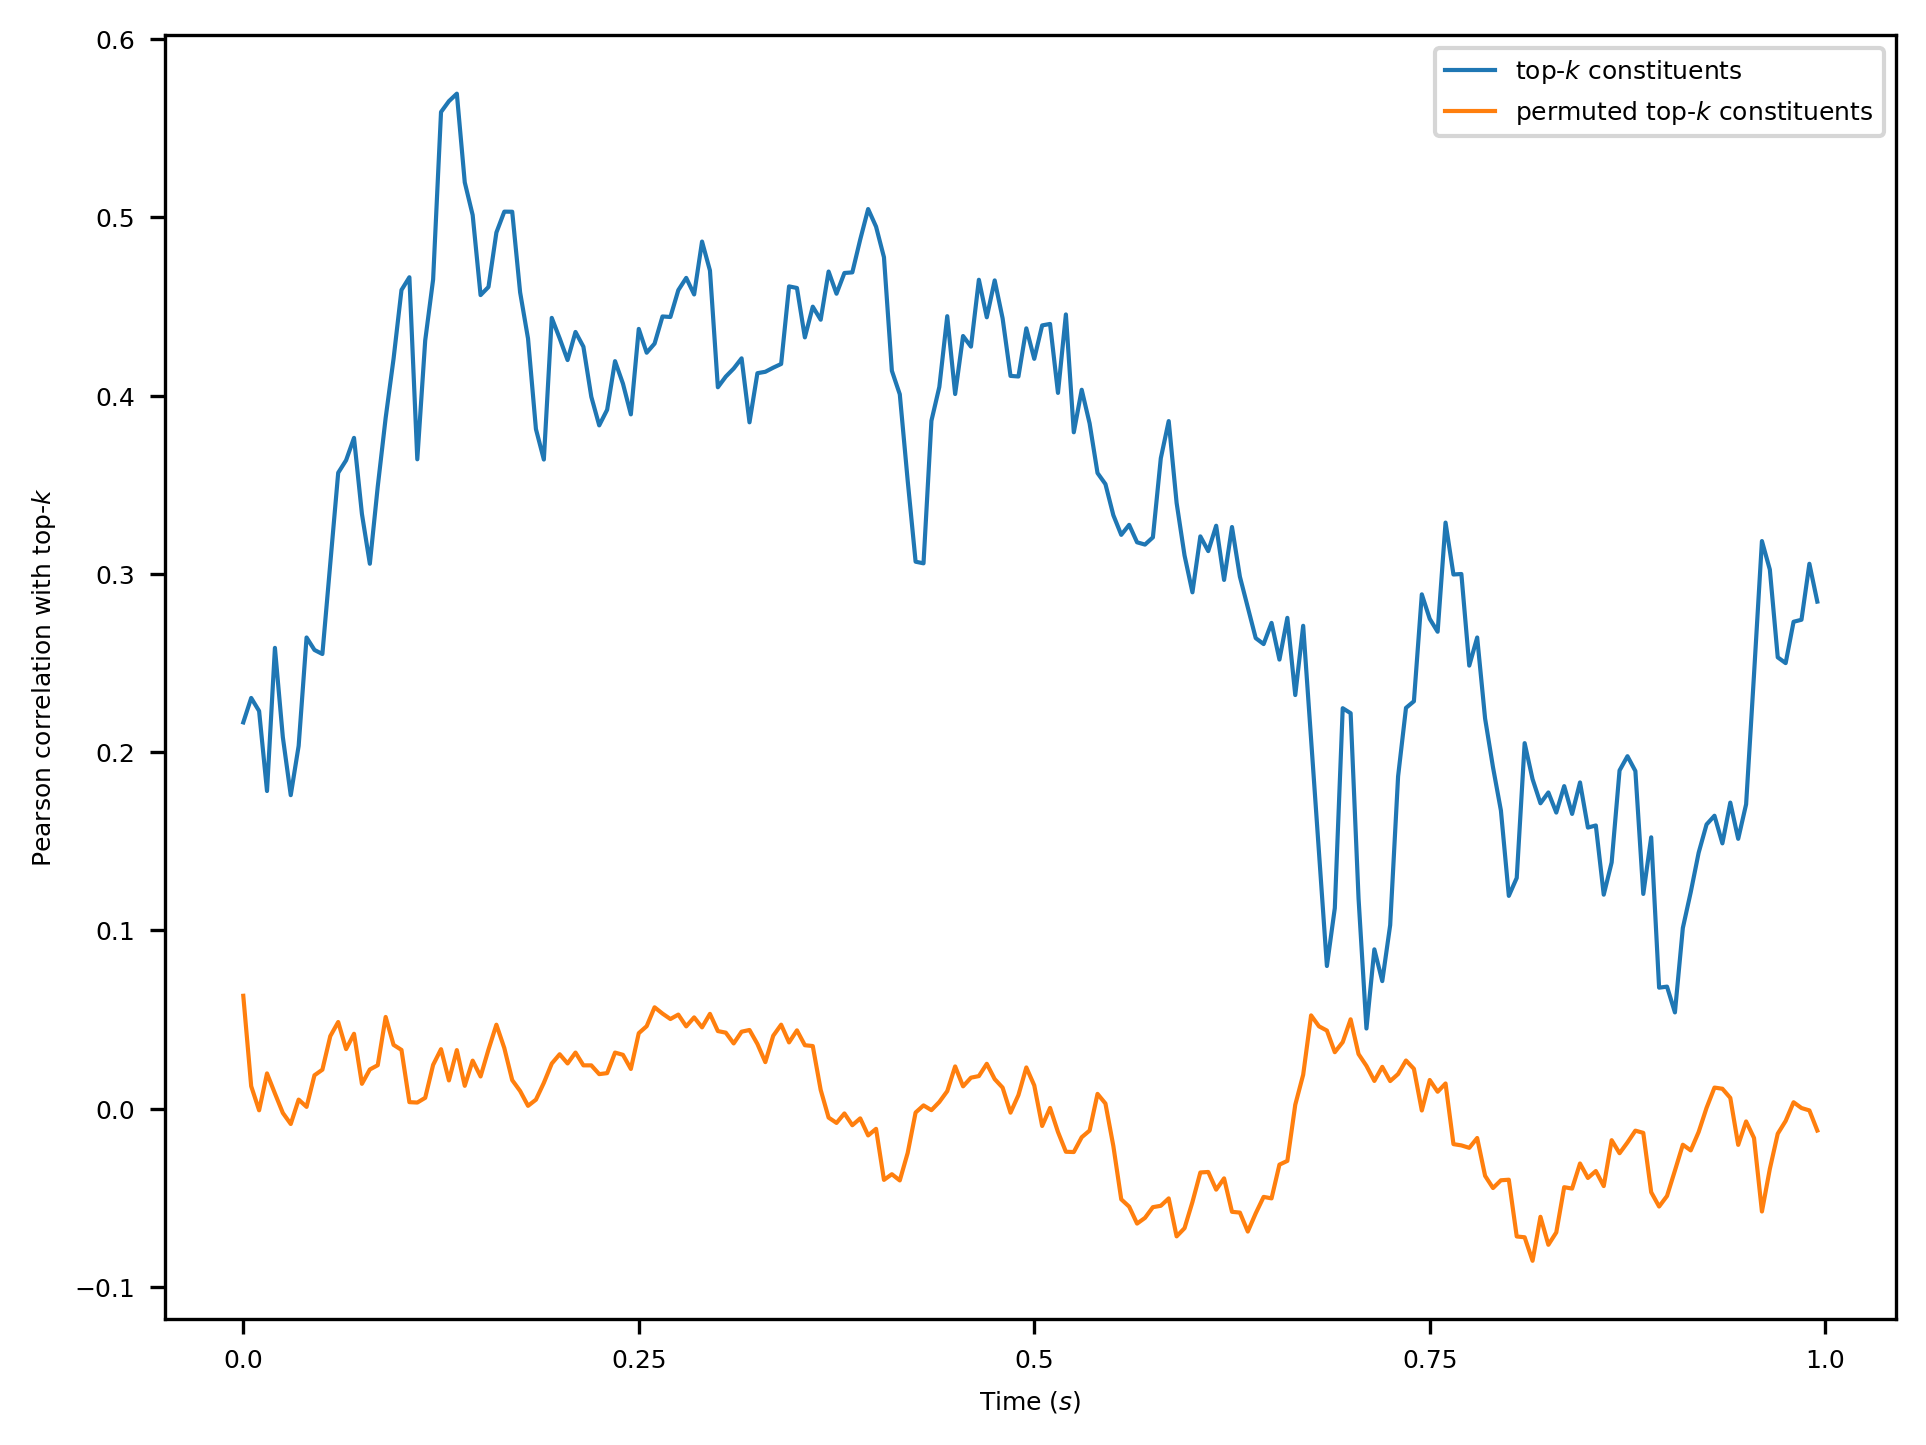

In [10]:
fig, ax = plt.subplots()

# plot
ax.plot(r, label = 'top-$k$ constituents')
ax.plot(r_perm, label = 'permuted top-$k$ constituents')

# cosmetics
ax.set_ylabel(r'Pearson correlation with top-$k$')
ax.set_xlabel(r'Time ($s$)')
ax.set_xticks(np.arange(0, 201, 50))
ax.set_xticklabels(np.arange(0, 201, 50)*5e-3)
ax.legend()
fig.tight_layout()

In [11]:
print(f'top-k:\t\tPearson r = {r.mean():.2f}')
print(f'permuted:\tPearson r = {r_perm.mean():.2f}')

top-k:		Pearson r = 0.32
permuted:	Pearson r = -0.00


So, overall, it substantial variance is, again, preserved here. Nice!